In [1]:
import pandas as pd
import zipfile

#load zip file
zf = zipfile.ZipFile('data.zip') 
#load train data
df_wafers = pd.read_csv(zf.open('df_wafers.csv'))
print(df_wafers.head())

#load test data
df_wafers_test = pd.read_csv(zf.open('df_wafers_test.csv'))
print(df_wafers_test.head())

  WaferName  DieX  DieY  IsGoodDie  IsScratchDie
0    3b2e28     0    12      False         False
1    3b2e28     0    13       True         False
2    3b2e28     0    14      False         False
3    3b2e28     0    15       True         False
4    3b2e28     0    16       True         False
  WaferName  DieX  DieY  IsGoodDie
0    5a6ad6     0    12      False
1    5a6ad6     0    13       True
2    5a6ad6     0    14       True
3    5a6ad6     0    15       True
4    5a6ad6     0    16       True


In [209]:
#split the data such that instead of containing rows of data, it will be matrixes of wafers

wafer_names = df_wafers['WaferName'].unique()



wafer_groups = df_wafers.groupby('WaferName')
df_wafers_split = [wafer_groups.get_group(wafer) for wafer in wafer_names]

#show a histogram of the wafer sizes
import matplotlib.pyplot as plt
import numpy as np

print(df_wafers_split[0].shape)
print(df_wafers_split[0].head())



(1005, 5)
  WaferName  DieX  DieY  IsGoodDie  IsScratchDie
0    3b2e28     0    12      False         False
1    3b2e28     0    13       True         False
2    3b2e28     0    14      False         False
3    3b2e28     0    15       True         False
4    3b2e28     0    16       True         False


In [210]:
print(len(df_wafers_split))
print(df_wafers_split[0].head())
print(df_wafers_split[0].shape)  

3920
  WaferName  DieX  DieY  IsGoodDie  IsScratchDie
0    3b2e28     0    12      False         False
1    3b2e28     0    13       True         False
2    3b2e28     0    14      False         False
3    3b2e28     0    15       True         False
4    3b2e28     0    16       True         False
(1005, 5)


For now lets check if we can clasiffy a wafer for having a scratch in it, using random forest classifier and  XGBoost classifier.

In [242]:
X = [df_wafers_split[i].drop(['WaferName','IsScratchDie'], axis=1) for i in range(len(df_wafers_split))]
y = [df_wafers_split[i]['IsScratchDie'].any() for i in range(len(df_wafers_split))]


#change the IsGoodDie column to 0 and 1 in X and the same for IsScratchDie in y
y = [1 if i == True else 0 for i in y]
X = [X[i].replace({'IsGoodDie': {True: 1, False: 0}}) for i in range(len(X))]




print(X[0].head())
print(y[0])

   DieX  DieY  IsGoodDie
0     0    12          0
1     0    13          1
2     0    14          0
3     0    15          1
4     0    16          1
1


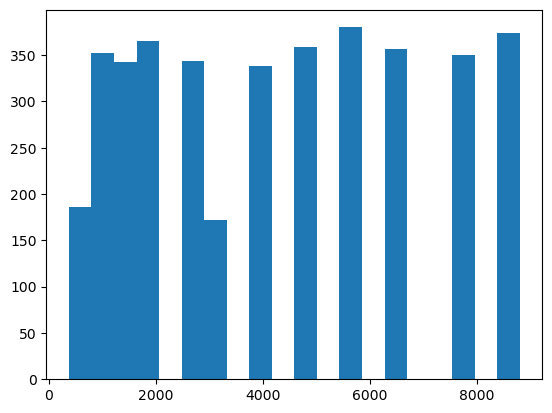

In [212]:
#show a histogram of the size of the wafers

import matplotlib.pyplot as plt
import numpy as np

def wafer_size_histogram(X):
    wafer_size = [X[i].shape[0] for i in range(len(X))]
    plt.hist(wafer_size, bins=20)
    plt.show()
    
wafer_size_histogram(X)
wafer_size = [X[i].shape[0] for i in range(len(X))]

In [243]:
#the wafers are not all the same size, so we need to pad the smaller ones with 0s rows

max_size = max(wafer_size)

X_padded = [X[i].append(pd.DataFrame(np.zeros((max_size - X[i].shape[0], X[i].shape[1])), columns=X[i].columns)) for i in range(len(X))]



C:\Users\galga\AppData\Local\Temp\ipykernel_62964\2822907265.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_padded = [X[i].append(pd.DataFrame(np.zeros((max_size - X[i].shape[0], X[i].shape[1])), columns=X[i].columns)) for i in range(len(X))]
C:\Users\galga\AppData\Local\Temp\ipykernel_62964\2822907265.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_padded = [X[i].append(pd.DataFrame(np.zeros((max_size - X[i].shape[0], X[i].shape[1])), columns=X[i].columns)) for i in range(len(X))]
C:\Users\galga\AppData\Local\Temp\ipykernel_62964\2822907265.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_padded = [X[i].append(pd.DataFrame(np.zeros((max_size - X[i].shape[0], X[i].shape[1])), columns=X[i].columns)) for i i

In [215]:
# flatten the X matrixes
X_flat = [X_padded[i].values.flatten() for i in range(len(X_padded))]
print(X_flat[0].shape)


(26391,)


In [238]:
from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from tqdm import tqdm


X = X_flat.copy()

#split the data into training and testing data
print("splitting data")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#train the model
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
print("training model rf")
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
print(rf.score(X_train, y_train))





splitting data
training model rf
0.9961734693877551
0.9987244897959183


[[771   6]
 [  0 791]]


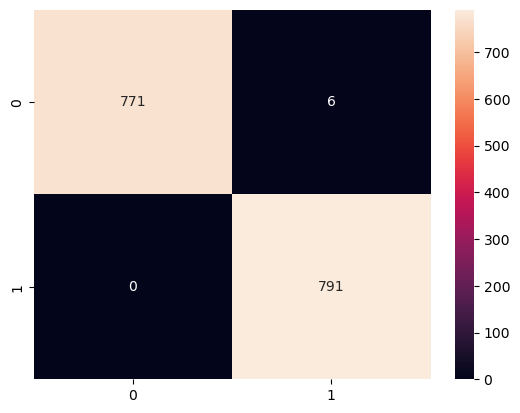

In [239]:
#make confusion matrix of the model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)


sns.heatmap(cm, annot=True, fmt='d')    
plt.show()


In [150]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
print("training model xgb")
xgb_model.fit(X_train, y_train)

#test the model
print(xgb_model.score(X_test, y_test))

training model xgb
0.9936224489795918


In [195]:
def classify_if_contains_scratch(wafer):
    wafer = wafer.drop(['WaferName','IsScratchDie'], axis=1)
    wafer = wafer.replace({'IsGoodDie': {True: 1, False: 0}})
    #pad the wafer with 0s
    wafer = wafer.append(pd.DataFrame(np.zeros((max_size - wafer.shape[0], wafer.shape[1])), columns=wafer.columns))
    #flatten the wafer
    wafer = wafer.values.flatten()
    #predict if the wafer contains a scratch
    return rf.predict([wafer])

In [240]:
import numpy as np
from tqdm import tqdm

success_scratch = 0
success_no_scratch = 0

# filter wafers that contain scratches
scratch_df = df_wafers[df_wafers['IsScratchDie'] == True]['WaferName']

# filter wafers that do not contain scratches
no_scratch_wafers = df_wafers.groupby('WaferName')['IsScratchDie'].any()
no_scratch_wafers = no_scratch_wafers[no_scratch_wafers == False].index.tolist()

# use tqdm to add a progress bar
for i in tqdm(range(100)):
    # take one random wafer that contains scratches
    scratch_wafer_name = np.random.choice(scratch_df, 1)[0]
    scratch_wafer = df_wafers[df_wafers['WaferName'] == scratch_wafer_name]

    # take one random wafer that does not contain scratches
    no_scratch_wafer_name = np.random.choice(no_scratch_wafers, 1)[0]
    no_scratch_wafer = df_wafers[df_wafers['WaferName'] == no_scratch_wafer_name]

    # classify if the wafers contain scratches or not
    res1 = classify_if_contains_scratch(scratch_wafer)
    res2 = classify_if_contains_scratch(no_scratch_wafer)

    # update success count for each class
    if res1 == 1:
        success_scratch += 1
    if res2 == 0:
        success_no_scratch += 1

print("success scratch: ", success_scratch)
print("success no scratch: ", success_no_scratch)


  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\galga\AppData\Local\Temp\ipykernel_62964\1795470908.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wafer = wafer.append(pd.DataFrame(np.zeros((max_size - wafer.shape[0], wafer.shape[1])), columns=wafer.columns))
C:\Users\galga\AppData\Local\Temp\ipykernel_62964\1795470908.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wafer = wafer.append(pd.DataFrame(np.zeros((max_size - wafer.shape[0], wafer.shape[1])), columns=wafer.columns))
  1%|          | 1/100 [00:01<03:01,  1.84s/it]C:\Users\galga\AppData\Local\Temp\ipykernel_62964\1795470908.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wafer = wafer.append(pd.DataFrame(np.zeros((max_size - wafer.shape[0], wafer.shape

success scratch:  100
success no scratch:  100


In [241]:
print("success scratch: ", success_scratch)
print("success no scratch: ", success_no_scratch)

success scratch:  100
success no scratch:  100


In [264]:
import numpy as np
import pandas as pd

X = X_flat.copy()

y = [df_wafers_split[i]['IsScratchDie'].replace({True: 1, False: 0}) for i in range(len(df_wafers_split))]

max_size = max([y[i].shape[0] for i in range(len(y))])
y_padded = [pd.concat([y[i], pd.Series(np.zeros(max_size - y[i].shape[0]))]) for i in range(len(y))]

print(y_padded[0].shape)

(8797,)


In [265]:
#make each y entry smaller take only the first 100 entries from each y

y_padded = [y_padded[i][:100] for i in range(len(y_padded))]

print(y_padded[0].shape)

(100,)


In [266]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

X_train, X_test, y_train, y_test = train_test_split(X, y_padded, test_size=0.4, random_state=42)

# create a random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# create a multioutput classifier with the random forest as the base estimator
multi_rf = MultiOutputClassifier(rf, n_jobs=-1)

# fit the multioutput classifier to the training data with a progress bar
batch_size = 500
for i in tqdm(range(0, len(X_train), batch_size)):
    multi_rf.fit(X_train[i:i+batch_size], y_train[i:i+batch_size])

# predict the values of multiple dice for the test data with a progress bar
batch_size = 100
y_pred = []
for i in tqdm(range(0, len(X_test), batch_size)):
    y_pred.extend(multi_rf.predict(X_test[i:i+batch_size]))

accuracy = accuracy_score(y_test, y_pred)



100%|██████████| 16/16 [18:33<00:00, 69.59s/it]


In [267]:
print(accuracy)

0.9572704081632653
